<br>
<h2>Purpose of this Notebook</h2><br>
This analysis aims to accurately predict house sale prices by leveraging advanced feature engineering techniques and various predictive models. Our focus has been on extracting meaningful insights from the data and enhancing model performance through meticulous feature selection and optimization.
<br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

# Introduction

By utilizing pertinent information from the dataset, this notebook seeks to develop a precise and trustworthy predictive model for sales price forecasting.
The emphasis is on using Lasso regression, which is well-known for its capacity to improve model accuracy through feature selection and overfitting reduction.
To make sure the model generalizes successfully new, unseen data, sophisticated data preparation techniques are used, such as feature engineering and robust handling of missing variables.
This all-encompassing strategy provides a strong basis for creating an effective and perceptive sales price forecast model.
Lasso regression is very helpful for corporate decision-making because it not only increases prediction accuracy but also makes model understanding easier.This method makes it easier to comprehend how each attribute affects the result by creating a linear relationship between the predictors and the target variable (sales price)

<h2>Initial Preparation</h2>

In [1]:
#########################
## importing libraries ##
#########################
# importing libraries
import pandas as pd                   # data science essentials
import matplotlib.pyplot as plt       # essential graphical output
import seaborn as sns                 # enhanced graphical output
from os import listdir                # Paths and directories
import statsmodels.formula.api as smf # Model building
import numpy as np                    # mathematical essentials
import warnings                       # warnings
from sklearn.model_selection import train_test_split # train/test split
from sklearn.neighbors import KNeighborsRegressor # KNN for Regression
from sklearn.preprocessing import StandardScaler  # standard scaler
import sklearn.linear_model

########################
## importing datasets ##
########################
# importing the training dataset
path             = "./"
training_dataset = "train.csv"

# testing set
testing_dataset  = "test.csv"


# reading in the training set
housing_train = pd.read_csv(filepath_or_buffer = path + training_dataset)


# reading in the testing set
housing_test = pd.read_csv(filepath_or_buffer = path + testing_dataset)

## This code will not generate an output ##

# Joining Datasets

Combining Datasets:
The training and testing datasets were combined into one unified DataFrame before performing any feature engineering. This ensures consistent transformations across both datasets and prevents issues during model evaluation. Two new features were added to manage the combined dataset:
‘set’: Identifies which rows belong to the training set and which belong to the testing set, preventing data leakage.
‘original_index’: Keeps track of the original row numbers, ensuring the data can be sorted back to its initial order if needed.


In [2]:
# creating new features to indicate original set
housing_train['set'] = 'Training'
housing_test ['set'] = 'Testing'

# concatenating both datasets together for mv and feature engineering
housing_df = pd.concat([housing_train, housing_test], axis=0)

# resetting index to avoid problems later in the code
housing_df.reset_index(drop = False,
                       inplace = True)


# changing the label for the original indexes
housing_df['original_index'] = housing_df['index']
housing_df.drop(labels = 'index', axis = 1, inplace = True)

# checking results
housing_df.head(n = 5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,set,original_index
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500.0,Training,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500.0,Training,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500.0,Training,2
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,Training,3
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000.0,Training,4


# EDA - Data Exploration

#### Missing Values:
The EDA phase highlighted several features containing missing values. A large number of nulls for these features suggest problems with data collection or feature relevance.
To maintain local trends and prevent bias, the missing values for "LotFrontage" were filled in using the average value within each neighborhood. This method tries to preserve the connection between lot size and property location, which can have impact on the forecasts.
#### Categorical Features:
In order to develope a deep analysis of the data, it's necessary to define categorical Features and dummies. Some of the original features contained multiple "NA" which, according to the data description dictionary, represent the missing of a feature in the house and they are not missing values. Fist of all we filled up the "NA" Missing Values with characters "NA" to then be able to categorize these data. As mentioned, we then categorized the data and created dummies to allow Data Analysis like Correlations and Modeling.  
#### Numerical Features:
Although explicit distribution plots were not shown, numerical features were investigated using logical transformations and imputation approaches. Estimates revealed significant variance within neighborhoods, highlighting the importance of location for the definition of a Sale Price. 
#### Consistency in Data Processing: 
The analysis preserved consistency in data processing by linking the training and testing datasets. During model deployment, this lowers the possibility of feature mismatch and guarantees that both sets go through the same transformations. That also allowed to develop features that can be valuable in the modeling phase. 
#### Feature Correlations:
Possible Influential Features 'Neighborhood', 'GarageType', 'MasVnrType', and 'FireplaceQu' are expected to have a high predictive potential based on the transformations and handling observed. The structural and location-based characteristics of properties are captured by these features, which are crucial factors in real estate sales price modeling.  

# Data Preprocessing

Before the modelling part for housing price prediction, the main purpose of data pre-pocessing is to help the model correctly understand the characteristics of house, not just to randomly fill in blanks for missing values. For example, if the basement or garage area data is missing, it means (According to the data description) that there is no basement and garage in the house, therefore, we use "NA" to fill in the missing values and then "0" when encoded.
All the steps in this part is aiming to make sure the data can truly reflect house features, so that the following model predictions could better match the actual market situation.

In [3]:
#Calculate the average LotFrontage for each Neighborhood
neighborhood_avg_lotfrontage = housing_df.groupby("Neighborhood")["LotFrontage"].transform("mean")
# Fill NA values in LotFrontage with the corresponding Neighborhood average
housing_df["LotFrontage"] = housing_df["LotFrontage"].fillna(neighborhood_avg_lotfrontage)

# Fill NA values with string NA for object types and 0 for numeric types
housing_df["MasVnrType"] = housing_df["MasVnrType"].replace("None", "NA")
housing_df["Alley"] = housing_df["Alley"].fillna("NA")
housing_df["MasVnrType"] = housing_df["MasVnrType"].fillna("NA")
housing_df["BsmtFinType1"] = housing_df["BsmtFinType1"].fillna("NA")
housing_df["Electrical"] = housing_df["Electrical"].fillna("NA")
housing_df["FireplaceQu"] = housing_df["FireplaceQu"].fillna("NA")
housing_df["GarageType"] = housing_df["GarageType"].fillna("NA")
housing_df["GarageFinish"] = housing_df["GarageFinish"].fillna("NA")
housing_df["GarageCond"] = housing_df["GarageCond"].fillna("NA")
housing_df["PoolQC"] = housing_df["PoolQC"].fillna("NA")
housing_df["Fence"] = housing_df["Fence"].fillna("NA")
housing_df["MiscFeature"] = housing_df["MiscFeature"].fillna("NA")
housing_df["BsmtQual"] = housing_df["BsmtQual"].fillna("NA")
housing_df["BsmtCond"] = housing_df["BsmtCond"].fillna("NA")
housing_df["BsmtExposure"] = housing_df["BsmtExposure"].fillna("NA")
housing_df["BsmtFinType2"] = housing_df["BsmtFinType2"].fillna("NA")
housing_df["GarageYrBlt"] = housing_df["GarageYrBlt"].fillna(0)
housing_df["GarageQual"] = housing_df["GarageQual"].fillna("NA")
housing_df["Utilities"] = housing_df["Utilities"].fillna("NA")
housing_df["MSZoning"] = housing_df["MSZoning"].fillna("NA")
housing_df["Exterior1st"] = housing_df["Exterior1st"].fillna("NA")
housing_df["Exterior2nd"] = housing_df["Exterior2nd"].fillna("NA")
housing_df["KitchenQual"] = housing_df["KitchenQual"].fillna("NA")
housing_df["Functional"] = housing_df["Functional"].fillna("NA")
housing_df["SaleType"] = housing_df["SaleType"].fillna("NA")
housing_df["BsmtFinSF1"] = housing_df["BsmtFinSF1"].fillna(0)
housing_df["BsmtFinSF2"] = housing_df["BsmtFinSF2"].fillna(0)
housing_df["TotalBsmtSF"] = housing_df["TotalBsmtSF"].fillna(0)
housing_df["BsmtUnfSF"] = housing_df["BsmtUnfSF"].fillna(0)
housing_df["BsmtFullBath"] = housing_df["BsmtFullBath"].fillna(0)
housing_df["BsmtHalfBath"] = housing_df["BsmtHalfBath"].fillna(0)
housing_df["GarageCars"] = housing_df["GarageCars"].fillna(0)
housing_df["GarageArea"] = housing_df["GarageArea"].fillna(0)
housing_df["MasVnrArea"] = housing_df["MasVnrArea"].fillna(0)

## Encoding Categorical Features

In [4]:
# Codify OverallQual

# Initialize an empty list to store the encoded values
overalqual_encoded = []
# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["OverallQual"] == "Very Excellent":
        overalqual_encoded.append(10)
    elif row["OverallQual"] == "Excellent":
        overalqual_encoded.append(9)
    elif row["OverallQual"] == "Very Good":
        overalqual_encoded.append(8)
    elif row["OverallQual"] == "Good":
        overalqual_encoded.append(7)
    elif row["OverallQual"] == "Above Average":
        overalqual_encoded.append(6)
    elif row["OverallQual"] == "Average":
        overalqual_encoded.append(5)
    elif row["OverallQual"] == "Below Average":
        overalqual_encoded.append(4)
    elif row["OverallQual"] == "Fair":
        overalqual_encoded.append(3)
    elif row["OverallQual"] == "Poor":
        overalqual_encoded.append(2)
    elif row["OverallQual"] == "Very Poor":
        overalqual_encoded.append(1)
    else:
        # Handle any unexpected values if necessary
        overalqual_encoded.append(0)

# Create new column for encoded version
housing_df["OverallQual_encoded"] = overalqual_encoded

In [5]:
# Codify OverallCond

# Initialize an empty list to store the encoded values
OverallCond_encoded = []
# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["OverallCond"] == "Very Excellent":
        OverallCond_encoded.append(10)
    elif row["OverallCond"] == "Excellent":
        OverallCond_encoded.append(9)
    elif row["OverallCond"] == "Very Good":
        OverallCond_encoded.append(8)
    elif row["OverallCond"] == "Good":
        OverallCond_encoded.append(7)
    elif row["OverallCond"] == "Above Average":
        OverallCond_encoded.append(6)
    elif row["OverallCond"] == "Average":
        OverallCond_encoded.append(5)
    elif row["OverallCond"] == "Below Average":
        OverallCond_encoded.append(4)
    elif row["OverallCond"] == "Fair":
        OverallCond_encoded.append(3)
    elif row["OverallCond"] == "Poor":
        OverallCond_encoded.append(2)
    elif row["OverallCond"] == "Very Poor":
        OverallCond_encoded.append(1)
    else:
        # Handle any unexpected values if necessary
        OverallCond_encoded.append(0)

# Create new column for encoded version
housing_df["OverallCond_encoded"] = OverallCond_encoded

In [6]:
# Codify ExterQual

# Initialize an empty list to store the encoded values
exterqual_encoded = []
# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["ExterQual"] == "Ex":
        exterqual_encoded.append(5)
    elif row["ExterQual"] == "Gd":
        exterqual_encoded.append(4)
    elif row["ExterQual"] == "TA":
        exterqual_encoded.append(3)
    elif row["ExterQual"] == "Fa":
        exterqual_encoded.append(2)
    elif row["ExterQual"] == "Po":
        exterqual_encoded.append(1)
    else:
        # Handle any unexpected values if necessary
        exterqual_encoded.append(None)

# Create new column for encoded version
housing_df["ExterQual_encoded"] = exterqual_encoded

In [7]:
# Codify ExterCond

# Initialize an empty list to store the encoded values
extercond_encoded = []
# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["ExterCond"] == "Ex":
        extercond_encoded.append(5)
    elif row["ExterCond"] == "Gd":
        extercond_encoded.append(4)
    elif row["ExterCond"] == "TA":
        extercond_encoded.append(3)
    elif row["ExterCond"] == "Fa":
        extercond_encoded.append(2)
    elif row["ExterCond"] == "Po":
        extercond_encoded.append(1)
    else:
        # Handle any unexpected values if necessary
        extercond_encoded.append(None)

# Create new column for encoded version        
housing_df["ExterCond_encoded"] = extercond_encoded

In [8]:
# Codify BsmtQual
housing_df["BsmtQual"] = housing_df["BsmtQual"].fillna("NA")

# Initialize an empty list to store the encoded values
bsmtqual_encoded = []

# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["BsmtQual"] == "Ex":
        bsmtqual_encoded.append(5)
    elif row["BsmtQual"] == "Gd":
        bsmtqual_encoded.append(4)
    elif row["BsmtQual"] == "TA":
        bsmtqual_encoded.append(3)
    elif row["BsmtQual"] == "Fa":
        bsmtqual_encoded.append(2)
    elif row["BsmtQual"] == "Po":
        bsmtqual_encoded.append(1)
    elif row["BsmtQual"] == "NA":
        bsmtqual_encoded.append(0)
    else:
        # Handle any unexpected values
        bsmtqual_encoded.append(None)

# Create a new column with the encoded values
housing_df["BsmtQual_encoded"] = bsmtqual_encoded


In [9]:
# Codify BsmtCond
housing_df["BsmtCond"] = housing_df["BsmtCond"].fillna("NA")

# Initialize an empty list to store the encoded values
bsmtcond_encoded = []

# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["BsmtCond"] == "Ex":
        bsmtcond_encoded.append(5)
    elif row["BsmtCond"] == "Gd":
        bsmtcond_encoded.append(4)
    elif row["BsmtCond"] == "TA":
        bsmtcond_encoded.append(3)
    elif row["BsmtCond"] == "Fa":
        bsmtcond_encoded.append(2)
    elif row["BsmtCond"] == "Po":
        bsmtcond_encoded.append(1)
    elif row["BsmtCond"] == "NA":
        bsmtcond_encoded.append(0)
    else:
        # Handle any unexpected values
        bsmtcond_encoded.append(None)

# Create a new column with the encoded values
housing_df["BsmtCond_encoded"] = bsmtcond_encoded


In [10]:
# Codify HeatingQC

# Initialize an empty list to store the encoded values
heatingqc_encoded = []
# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["HeatingQC"] == "Ex":
        heatingqc_encoded.append(5)
    elif row["HeatingQC"] == "Gd":
        heatingqc_encoded.append(4)
    elif row["HeatingQC"] == "TA":
        heatingqc_encoded.append(3)
    elif row["HeatingQC"] == "Fa":
        heatingqc_encoded.append(2)
    elif row["HeatingQC"] == "Po":
        heatingqc_encoded.append(1)
    elif row["HeatingQC"] == "NA":
        heatingqc_encoded.append(0)
    else:
        # Handle any unexpected values if necessary
        heatingqc_encoded.append(None)

# Create new column for encoded version
housing_df["HeatingQC_encoded"] = heatingqc_encoded


In [11]:
# Codify KitchenQual

# Initialize an empty list to store the encoded values
kitchenqual_encoded = []
# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["KitchenQual"] == "Ex":
        kitchenqual_encoded.append(5)
    elif row["KitchenQual"] == "Gd":
        kitchenqual_encoded.append(4)
    elif row["KitchenQual"] == "TA":
        kitchenqual_encoded.append(3)
    elif row["KitchenQual"] == "Fa":
        kitchenqual_encoded.append(2)
    elif row["KitchenQual"] == "Po":
        kitchenqual_encoded.append(1)
    else:
        # Handle any unexpected values if necessary
        kitchenqual_encoded.append(0)

# Create new column for encoded version
housing_df["KitchenQual_encoded"] = kitchenqual_encoded


In [12]:
# Codify GarageQual

# Initialize an empty list to store the encoded values
garagequal_encoded = []
# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["GarageQual"] == "Ex":
        garagequal_encoded.append(5)
    elif row["GarageQual"] == "Gd":
        garagequal_encoded.append(4)
    elif row["GarageQual"] == "TA":
        garagequal_encoded.append(3)
    elif row["GarageQual"] == "Fa":
        garagequal_encoded.append(2)
    elif row["GarageQual"] == "Po":
        garagequal_encoded.append(1)
    elif row["GarageQual"] == "NA":
        garagequal_encoded.append(0)
    else:
        # Handle any unexpected values if necessary
        garagequal_encoded.append(None)

# Create new column for encoded version
housing_df["GarageQual_encoded"] = garagequal_encoded


In [13]:
#Dealing with Garage Condition
housing_df["GarageCond"] = housing_df["GarageCond"].fillna("NA")

# Initialize an empty list to store the encoded values
garagecond_encoded = []

# Iterate over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["GarageCond"] == "NA":
        garagecond_encoded.append(0)
    elif row["GarageCond"] == "Po":
        garagecond_encoded.append(1)
    elif row["GarageCond"] == "Fa":
        garagecond_encoded.append(2)
    elif row["GarageCond"] == "TA":
        garagecond_encoded.append(3)
    elif row["GarageCond"] == "Gd":
        garagecond_encoded.append(4)
    elif row["GarageCond"] == "Ex":
        garagecond_encoded.append(5)
    else:
        # Handle any unexpected values if necessary
        garagecond_encoded.append(None)

# Create a new column with the encoded values
housing_df["GarageCond_encoded"] = garagecond_encoded

In [14]:
#codify Fireplace Quality
housing_df["FireplaceQu"] = housing_df["FireplaceQu"].fillna("NA")

# Initialize an empty list to store the encoded values
fireplace_encoded = []

# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["FireplaceQu"] == "Ex":
        fireplace_encoded.append(5)
    elif row["FireplaceQu"] == "Gd":
        fireplace_encoded.append(4)
    elif row["FireplaceQu"] == "TA":
        fireplace_encoded.append(3)
    elif row["FireplaceQu"] == "Fa":
        fireplace_encoded.append(2)
    elif row["FireplaceQu"] == "Po":
        fireplace_encoded.append(1)
    elif row["FireplaceQu"] == "NA":
        fireplace_encoded.append(0)
    else:
        # Handle any unexpected values if necessary
        fireplace_encoded.append(None)

# Create a new column with the encoded values
housing_df["FireplaceQu_encoded"] = fireplace_encoded


In [15]:
#dealing with Pool Condition
housing_df["PoolQC"] = housing_df["PoolQC"].fillna("NA")

# Initialize an empty list to store the encoded values
poolqc_encoded = []

# Loop over each row in the DataFrame
for index, row in housing_df.iterrows():
    if row["PoolQC"] == "NA":
        poolqc_encoded.append(0)
    elif row["PoolQC"] == "Fa":
        poolqc_encoded.append(1)
    elif row["PoolQC"] == "TA":
        poolqc_encoded.append(2)
    elif row["PoolQC"] == "Gd":
        poolqc_encoded.append(3)
    elif row["PoolQC"] == "Ex":
        poolqc_encoded.append(4)
    else:
        # Handle any unexpected values if necessary
        poolqc_encoded.append(None)

# Create a new column with the encoded values
housing_df["PoolQC_encoded"] = poolqc_encoded


# Feature Engeneering

Feature engineering is crucial to enhancing the model's predictive power since it transforms unstructured data into valuable input features. 
The complex relationships that influence sales price were then captured by combining important factors like OverallQual and GrLivArea to create interactive features. These interactions provide a more nuanced picture of how property qualities impact pricing overall. 

Features:
##### 1. House Age at Sale
This feature represents the age of the house at the time of sale. It's calculated by subtracting the year the house was built from the year it was sold with the goal of capture the depreciation of property over time.
(Mosaik Real Estate, 2024)

##### 2. Years Since Remodel
It measures the number of years since the house was last remodeled, which is computed as the difference between the year sold and the last remodel year. All the negative results of this computation are corrected to zero. This feature aims to quantify the impact of recent upgrades on the house's market value, as newer remodels can significantly increase a property's value.
(Associated Press, 2024)

##### 3. Total Finished Living Area
This feature aggregates the total area of the first and second floors with the finished basement areas. The goal is to highlight larger living spaces which generally translates in higher prices, making this a crucial variable for predicting house prices.
(Homes.com, 2024)

##### 4. Total Bathrooms
This is a sum of all bathrooms, with half bathrooms counted as 0.5, providing a total count of usable bathroom facilities. The number of bathrooms is a major factor in home valuation as they directly contribute to the level of functionality , privacy and comfort.
(Homes.com, 2024)

##### 5. Total Porch Area
It adds up the areas of all porch types to give a single measure of total porch space. The foal of this feature is to highlight the outdoor living spaces like porches considering that they can enhance the attractiveness and living experience of a home,and potentially influence its sale price.
(Landmark Fine Homes, 2024)

##### 6. Quality Composite Score
It averages encoded quality ratings from multiple features (overall quality, exterior quality, basement quality, kitchen quality, and garage quality) in a single number. This composite score provides a holistic measure of the property’s condition and quality, which are decisive for pricing.
(Stephanie Young Group, 2024)

##### 7. Bedroom-to-Total Room Ratio
This feature calculates the ratio of bedrooms to total rooms, adjusting for any zero values to avoid undefined calculations. The ratio offers insight into the layout's functionality, which can appeal differently to various buyer demographics.
(Homes.com, 2024)

In [16]:
# Feature 1: House Age at Sale
housing_df['HouseAge'] = housing_df['YrSold'] - housing_df['YearBuilt']

# Feature 2: Years Since Remodel
housing_df['YearsSinceRemod'] = housing_df['YrSold'] - housing_df['YearRemodAdd']
housing_df['YearsSinceRemod'] = housing_df['YearsSinceRemod'].apply(lambda x: max(x, 0))

# Feature 3: Total Finished Living Area
housing_df['TotalLivingArea'] = (housing_df['1stFlrSF'] + housing_df['2ndFlrSF'] +
                                    housing_df['BsmtFinSF1'] + housing_df['BsmtFinSF2'])

# Feature 4: Total Bathrooms
housing_df['TotalBaths'] = (housing_df['FullBath'] + housing_df['BsmtFullBath'] +
                               0.5 * (housing_df['HalfBath'] + housing_df['BsmtHalfBath']))

# Feature 5: Total Porch Area
housing_df['TotalPorchSF'] = (housing_df['WoodDeckSF'] + housing_df['OpenPorchSF'] +
                                 housing_df['EnclosedPorch'] + housing_df['3SsnPorch'] +
                                 housing_df['ScreenPorch'])

# Feature 6: Quality Composite Score (Average of quality ratings)
housing_df['QualityIndex'] = (housing_df['OverallQual_encoded'] + housing_df['ExterQual_encoded'] +
                                 housing_df['BsmtQual_encoded'] + housing_df['KitchenQual_encoded'] +
                                 housing_df['GarageQual_encoded']) / 5

# Feature 7: Bedroom-to-Total Room Ratio
housing_df['Bedroom_to_TotalRoom_Ratio'] = housing_df['BedroomAbvGr'] / housing_df['TotRmsAbvGrd'].replace(0, np.nan)


###### 8. Seasonal Feature Creation:
A new feature called ‘SeasonSold’ was created to capture the seasonality effect on revenue. This was calculated using the month of sale (‘MoSold’), and categorized into:

- Winter: December, January, February
- Spring: March, April, May
- Summer: June, July, August
- Fall: September, October, November

This feature helps the model understand seasonal trends in revenue, such as peak selling periods or slower seasons.
 
Visualizing Seasonal Effects:
A bar plot was created to show the average revenue for each season, revealing that:
- Summer and Spring have higher average revenues compared to Winter and Fall.
- This shows a clear seasonal impact on revenue, validating the importance of the ‘SeasonSold’ feature.

This visualization enhances the interpretability of the model by providing insights into how seasonal trends influence revenue.

In [17]:
#define a UDF to highlight in which month the house was sold

#Seasonality of Sale
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter' #winter
    elif month in [3, 4, 5]:
        return 'Spring' #spring
    elif month in [6, 7, 8]:
        return 'Summer' #summer
    elif month in [9, 10, 11]:
        return 'Fall'   #fall
    else:
        return 'NA'

# Create new column to store values
housing_df['SeasonSold'] = housing_df['MoSold'].apply(get_season)


## 4.⁠ ⁠Visualization of Seasonal Trends

The trend in the seasons can be seen clearly in the graphs.

The graphs shows:
- The Average Housing Sale Price (green line) 
- Number of Houses Sold (purple bars) by month.

It offers crucial information on the monthly and seasonal trends in the real estate market, which is essential for creating a precise prediction model that can better predict the housing sale price in different seasons.

The graphs show the variations in the number of homes sold and average housing sale prices over the course of the year. As we can see, sales peak in June (Month 6) and July (Month 7). December (Month 12) had the lowest quantity of houses sold. During the month with higher demand, the graphics show a lower average housing sale price compared to the months with lower demand. 
This clearly shows the impact of seasons and specific months in the definition of housing sale price.

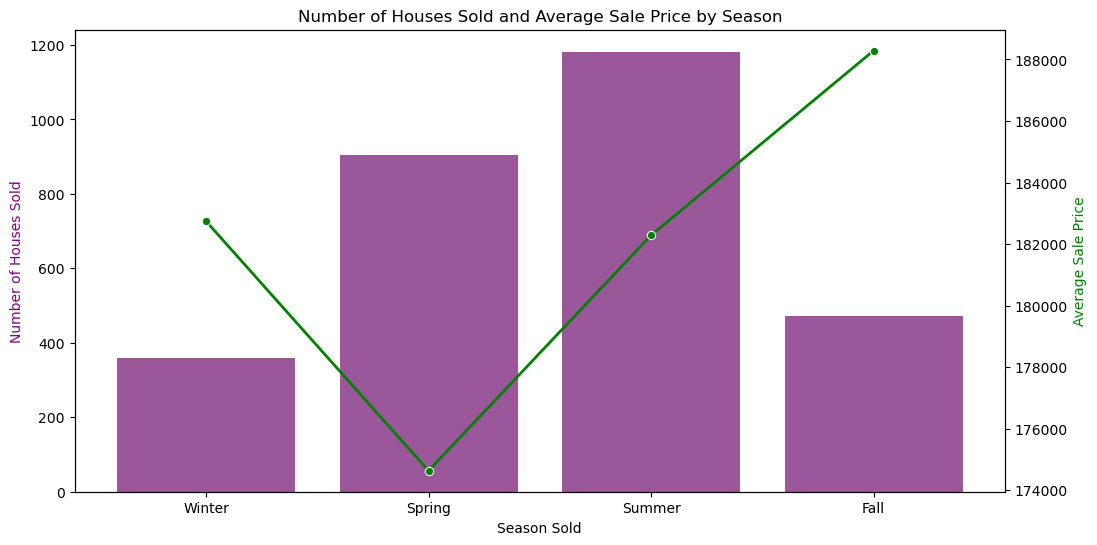

In [18]:
# Count how many houses sold in each season
count_by_season = housing_df.groupby('SeasonSold')['Id'].count().reset_index()
count_by_season.columns = ['SeasonSold', 'HouseCount']

# Calculate the average sale price by season
price_by_season = housing_df.groupby('SeasonSold')['SalePrice'].mean().reset_index()
price_by_season.columns = ['SeasonSold', 'AveragePrice']


# Sort seasons in a logical order (optional)
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
count_by_season['SeasonSold'] = pd.Categorical(count_by_season['SeasonSold'], categories=season_order, ordered=True)
price_by_season['SeasonSold'] = pd.Categorical(price_by_season['SeasonSold'], categories=season_order, ordered=True)

# Sort the DataFrames by season so the bars and line up
count_by_season.sort_values('SeasonSold', inplace=True)
price_by_season.sort_values('SeasonSold', inplace=True)

# Create the figure and first axis (for the bar chart)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar chart of house counts
sns.barplot(data=count_by_season, x='SeasonSold', y='HouseCount',
            ax=ax1, color='purple', alpha=0.7)

ax1.set_title('Number of Houses Sold and Average Sale Price by Season')
ax1.set_ylabel('Number of Houses Sold', color='purple')
ax1.set_xlabel('Season Sold')

# Create a second y-axis (for the line chart)
ax2 = ax1.twinx()

# Plot the average sale price as a line
sns.lineplot(data=price_by_season, x='SeasonSold', y='AveragePrice',
             ax=ax2, color='green', marker='o', linewidth=2)

ax2.set_ylabel('Average Sale Price', color='green')

# Display the plot
plt.show()

This visualization shows the seasonal trends in house sales and their average prices. During the winter, the number of houses sold is the lowest, but the trend reverses dramatically as sales peak in the summer. The average sale price behaves in an opposite way. It starts lower in winter and reaching the highest point in fall. The graph effectively displays a discrepancy between the volume of sales and the average pricing, suggesting different market dynamics per season. The graphs shows possible seasonal influences on buyers' and sellers' behaviors.

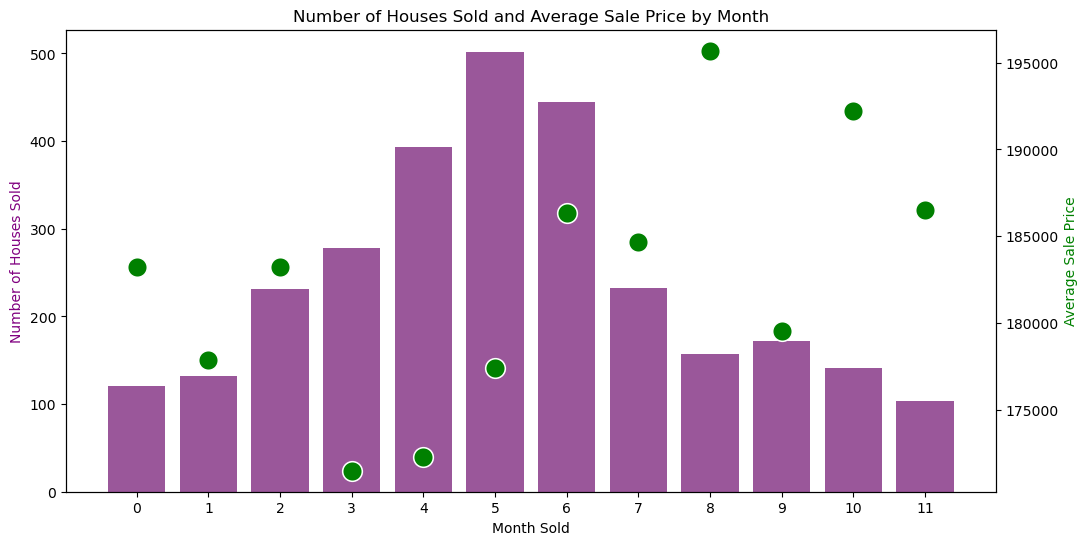

In [19]:
# Count how many houses sold in each month
count_by_month = housing_df.groupby('MoSold')['Id'].count().reset_index()
count_by_month.columns = ['MoSold', 'HouseCount']

# Calculate the average sale price by month
price_by_month = housing_df.groupby('MoSold')['SalePrice'].mean().reset_index()
price_by_month.columns = ['MoSold', 'AveragePrice']

# Merge into a single DataFrame on 'MoSold'
month_data = pd.merge(count_by_month, price_by_month, on='MoSold', how='outer') - 1

# Sort by 'MoSold' to ensure the order is correct
month_data.sort_values('MoSold', inplace=True)

# Create the figure and first axis (for the bar chart)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the bar chart of house counts
sns.barplot(data=month_data, x='MoSold', y='HouseCount',
            ax=ax1, color='purple', alpha=0.7)

ax1.set_title('Number of Houses Sold and Average Sale Price by Month')
ax1.set_ylabel('Number of Houses Sold', color='purple')
ax1.set_xlabel('Month Sold')

# Create a second y-axis (for the scatter plot)
ax2 = ax1.twinx()

# Plot the scatter plot for average price without the line
sns.scatterplot(data=month_data, x='MoSold', y='AveragePrice',
                ax=ax2, color='green', marker='o', s=200)

ax2.set_ylabel('Average Sale Price', color='green')

# Display the plot
plt.show()


This graph represents the number of houses sold and the average sale prices by month, visualized through a combination of bars and discrete markers. The volume of house sales exhibits a prominent peak during the summer months, particularly June and July, consistent with the previous graph that shows summer as the high season for sales. Contrasting with the previous seasonal graph, this monthly breakdown provides a more granular view, highlighting the sharp increase in sales as the weather warms up. The average sale price, represented by green dots, does not follow a consistent seasonal pattern as closely as the number of sales does, fluctuating across months. This visualization underlines that while more houses are sold in warmer months, the highest average prices don't necessarily coincide with these peaks.

# Creation of Encoded dataset

In [20]:
# Create dummy variables
housing_df_encoded = pd.get_dummies(housing_df, columns=[
    "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities",
    "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", 
    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
    "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", 
    "Functional", "GarageType", "GarageFinish", "PavedDrive", "Fence", 
    "MiscFeature", "SaleType", "SaleCondition", "SeasonSold"
])

# Convert from boolean to 1 and 0
housing_df_encoded = housing_df_encoded.astype({col: int for col in housing_df_encoded.select_dtypes(include=bool).columns})

# dropping objects types but not the set variable
housing_df_encoded = housing_df_encoded.drop(columns=[col for col in housing_df_encoded.select_dtypes(include=["object"]).columns if col != "set"])


# GO through every variable
for variable in [
    "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities",
    "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", 
    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
    "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", 
    "Functional", "GarageType", "GarageFinish", "PavedDrive", "Fence", 
    "MiscFeature", "SaleType", "SaleCondition", "SeasonSold"]:
    
    # Get all dummy columns for each variable
    dummy_columns = [c for c in housing_df_encoded.columns if c.startswith(f"{variable}_")]

    if dummy_columns:  # Ensure there are dummy columns for this category
        NA_columns = f"{variable}_NA"

        if NA_columns in dummy_columns:
            # Drop "NA" category if it exists
            housing_df_encoded = housing_df_encoded.drop(columns=[NA_columns])
        else:
            # Drop the most frequent category
            most_frequent_value = max(dummy_columns, key=lambda c: housing_df_encoded[c].sum())
            housing_df_encoded = housing_df_encoded.drop(columns=[most_frequent_value])
    else:
        continue

In [21]:
# Columns to move to the front
cols_to_move = ["original_index", "Id", "set", "SalePrice"]

# Get all other columns that are not in cols_to_move
remaining_cols = [col for col in housing_df_encoded.columns if col not in cols_to_move]

# Reorder the DataFrame
housing_df_encoded = housing_df_encoded[cols_to_move + remaining_cols]


In [22]:
# Columns to be moved
cols_to_move_two = ["HouseAge", "YearsSinceRemod", "TotalLivingArea", "TotalBaths", "TotalPorchSF",
                    "QualityIndex", "Bedroom_to_TotalRoom_Ratio"]

# Target index to move to
target_index = 40

# Get remaining columns
remaining_cols_two = [col for col in housing_df_encoded.columns if col not in cols_to_move_two]

# Split remaining_cols into elements before/after the target index
new_columns = (
    remaining_cols_two[:target_index]  # Columns before target_idx
    + cols_to_move_two              # Columns to insert
    + remaining_cols_two[target_index:]  # Columns after target_idx
)

# Reorder the DataFrame
housing_df_encoded = housing_df_encoded[new_columns]

In [23]:
# Rename columns to replace spaces and special characters
housing_df_encoded.columns = housing_df_encoded.columns.str.replace(" ", "_").str.replace("-", "_").str.replace(".", "_")

# Rename columns to not have special characters and to not start with numbers
housing_df_encoded = housing_df_encoded.rename(columns={
    "1stFlrSF": "FlrSF1st",
    "2ndFlrSF": "FlrSF2nd",
    "3SsnPorch": "SsnPorch3",
    "MSZoning_C_(all)": "MSZoning_C",
    "RoofMatl_Tar&Grv": "RoofMatl_Tar_Grv"
})

# Data Transformation

#### Log Transformation

In [24]:
# Transforms the data to log form and creates new column to store that data
housing_df_encoded["log_MSSubClass"]    = np.log1p(housing_df_encoded["MSSubClass"])
housing_df_encoded["log_LotFrontage"]   = np.log1p(housing_df_encoded["LotFrontage"])
housing_df_encoded["log_LotArea"]       = np.log1p(housing_df_encoded["LotArea"])
housing_df_encoded["log_OverallQual"]   = np.log1p(housing_df_encoded["OverallQual"])
housing_df_encoded["log_OverallCond"]   = np.log1p(housing_df_encoded["OverallCond"])
housing_df_encoded["log_MasVnrArea"]    = np.log1p(housing_df_encoded["MasVnrArea"])
housing_df_encoded["log_BsmtFinSF1"]    = np.log1p(housing_df_encoded["BsmtFinSF1"])
housing_df_encoded["log_BsmtFinSF2"]    = np.log1p(housing_df_encoded["BsmtFinSF2"])
housing_df_encoded["log_BsmtUnfSF"]     = np.log1p(housing_df_encoded["BsmtUnfSF"])
housing_df_encoded["log_TotalBsmtSF"]   = np.log1p(housing_df_encoded["TotalBsmtSF"])
housing_df_encoded["log_FlrSF1st"]      = np.log1p(housing_df_encoded["FlrSF1st"])
housing_df_encoded["log_FlrSF2nd"]      = np.log1p(housing_df_encoded["FlrSF2nd"])
housing_df_encoded["log_LowQualFinSF"]  = np.log1p(housing_df_encoded["LowQualFinSF"])
housing_df_encoded["log_GrLivArea"]     = np.log1p(housing_df_encoded["GrLivArea"])
housing_df_encoded["log_BsmtFullBath"]  = np.log1p(housing_df_encoded["BsmtFullBath"])
housing_df_encoded["log_BsmtHalfBath"]  = np.log1p(housing_df_encoded["BsmtHalfBath"])
housing_df_encoded["log_FullBath"]      = np.log1p(housing_df_encoded["FullBath"])
housing_df_encoded["log_HalfBath"]      = np.log1p(housing_df_encoded["HalfBath"])
housing_df_encoded["log_BedroomAbvGr"]  = np.log1p(housing_df_encoded["BedroomAbvGr"])
housing_df_encoded["log_KitchenAbvGr"]  = np.log1p(housing_df_encoded["KitchenAbvGr"])
housing_df_encoded["log_TotRmsAbvGrd"]  = np.log1p(housing_df_encoded["TotRmsAbvGrd"])
housing_df_encoded["log_Fireplaces"]    = np.log1p(housing_df_encoded["Fireplaces"])
housing_df_encoded["log_GarageYrBlt"]   = np.log1p(housing_df_encoded["GarageYrBlt"])
housing_df_encoded["log_GarageCars"]    = np.log1p(housing_df_encoded["GarageCars"])
housing_df_encoded["log_GarageArea"]    = np.log1p(housing_df_encoded["GarageArea"])
housing_df_encoded["log_WoodDeckSF"]    = np.log1p(housing_df_encoded["WoodDeckSF"])
housing_df_encoded["log_OpenPorchSF"]   = np.log1p(housing_df_encoded["OpenPorchSF"])
housing_df_encoded["log_EnclosedPorch"] = np.log1p(housing_df_encoded["EnclosedPorch"])
housing_df_encoded["log_SsnPorch3"]     = np.log1p(housing_df_encoded["SsnPorch3"])
housing_df_encoded["log_ScreenPorch"]   = np.log1p(housing_df_encoded["ScreenPorch"])
housing_df_encoded["log_PoolArea"]      = np.log1p(housing_df_encoded["PoolArea"])
housing_df_encoded["log_MiscVal"]       = np.log1p(housing_df_encoded["MiscVal"])
housing_df_encoded["log_MoSold"]        = np.log1p(housing_df_encoded["MoSold"])
housing_df_encoded['log_HouseAge'] = np.log1p(housing_df_encoded['HouseAge'])
housing_df_encoded['log_YearsSinceRemod'] = np.log1p(housing_df_encoded['YearsSinceRemod'])
housing_df_encoded['log_TotalLivingArea'] = np.log1p(housing_df_encoded['TotalLivingArea'])
housing_df_encoded['log_TotalBaths'] = np.log1p(housing_df_encoded['TotalBaths'])
housing_df_encoded['log_TotalPorchSF'] = np.log1p(housing_df_encoded['TotalPorchSF'])
housing_df_encoded['log_QualityIndex'] = np.log1p(housing_df_encoded['QualityIndex'])
housing_df_encoded['log_Bedroom_to_TotalRoom_Ratio'] = np.log1p(housing_df_encoded['Bedroom_to_TotalRoom_Ratio'])
housing_df_encoded["log_SalePrice"] = np.log1p(housing_df_encoded["SalePrice"])

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
# Fill NA values of log_YearsSinceRemod with 0
housing_df_encoded["log_YearsSinceRemod"] = housing_df_encoded["log_YearsSinceRemod"].fillna(0)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>
<h2> Pre-Model Building Process</h2>
Below is a template containing some of the standard steps in the model building process. Now that the training and testing sets have been combined, each step only needs to be conducted one time instead of multiple times.

<h3>Base Modeling</h3>

In [26]:
# Create the formula (No Logs)
#all the features selected
formula = "SalePrice ~ " + " + ".join(housing_df_encoded.columns[4:235])
lm_all = smf.ols(formula=formula, data=housing_df_encoded)

# Fit the model
results = lm_all.fit()

# Display summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     74.05
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:05:28   Log-Likelihood:                -16632.
No. Observations:                1460   AIC:                         3.369e+04
Df Residuals:                    1245   BIC:                         3.483e+04
Df Model:                         214                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [27]:
# Create the formula (Logs)
#all the log features selected
formula = "log_SalePrice ~ " + " + ".join(housing_df_encoded.columns[47:275])
lm_all = smf.ols(formula=formula, data=housing_df_encoded)

# Fit the model
results = lm_all.fit()

# Display summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:          log_SalePrice   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     91.01
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:05:28   Log-Likelihood:                 1336.3
No. Observations:                1460   AIC:                            -2235.
Df Residuals:                    1241   BIC:                            -1077.
Df Model:                         218                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.54

## Division of the dataset

In [28]:
## separating training and testing sets ##
#Important to allow model testing

# dataset for model building
training_data = pd.DataFrame(data  = housing_df_encoded[ housing_df_encoded['set'] == 'Training' ].copy())

# dataset for kaggle submission
kaggle_data   = pd.DataFrame(data = housing_df_encoded[ housing_df_encoded['set'] == 'Testing'  ].copy())

# dropping set identifier (training set)
training_data.drop(labels = 'set',
                   axis = 1,
                   inplace = True)


# dropping set identifier (testing set)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)

# Replace -inf values with 0
kaggle_data["log_HouseAge"] = kaggle_data["log_HouseAge"].replace(-np.inf, 0)

## Automatic Feature Selection

To optimize the selection of the feature for modelling a specific UDF has been used. It allows the user to define the tresholds and test automatically the mix of features for modelling basewd on the P value. 
This UDF was used to select the best features 

In [29]:
## Stepwise Selection for OLS Regression ##
def ols_stepwise_selection(x_data,
                           y_data, 
                           initial_list  = [], 
                           threshold_in  = 0.01, 
                           threshold_out = 0.05, 
                           verbose       = True):
    """
    Perform a forward-backward feature selection based on p-values from statsmodels.api.OLS.

    Arguments:
        x_data : pandas.DataFrame
            DataFrame with candidate features.
        y_data : array-like
            The target variable.
        initial_list : list
            List of features (column names of x) to start with.
        threshold_in : float
            Include a feature if its p-value < threshold_in.
        threshold_out : float
            Exclude a feature if its p-value > threshold_out.
        verbose : bool
            Whether to print the sequence of inclusions and exclusions.

    Returns:
        list
            The list of selected features.

    Note: Always set threshold_in < threshold_out to avoid infinite loops.
    """

    # required imports
    import statsmodels.api as sm
    import pandas as pd


    # setting placeholer list
    included = list(initial_list)


    # looping over each x-feature until there are no more significant p-values
    while True:
        changed = False

        # forward step: adding an x-feature
        excluded = [col for col in x_data.columns if col not in included]
        new_pvals = pd.Series(dtype = float, index = excluded)


        # fitting model with additional candidate feature
        for new_column in excluded:

            model = sm.OLS(y_data,
                           sm.add_constant(x_data[included + [new_column]])).fit()

            new_pvals[new_column] = model.pvalues[new_column]


        if not new_pvals.empty:
            best_pval = new_pvals.min()
            if best_pval < threshold_in:
                best_feature = new_pvals.idxmin()  # Use idxmin() instead of argmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))


        # backward step: potentially removing an x-feature
        if included:
            model = sm.OLS(y_data, sm.add_constant(x_data[included])).fit()

            # excluding intercept p-value (first element)
            pvals = model.pvalues.iloc[1:]

            # ensuring the model is not empty
            if not pvals.empty:
                worst_pval = pvals.max()
                if worst_pval > threshold_out:
                    worst_feature = pvals.idxmax()  # Use idxmax() instead of argmax()
                    included.remove(worst_feature)
                    changed = True
                    if verbose:
                        print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))


        # stopping the loop if optimized
        if not changed:
            break


    # returning stepwise model's x-features
    return included

In [30]:
# The following code is to call the function for Automatic selection. We Hard Coded our results to not waste time running it again
# selected_features = ols_stepwise_selection(
#     x_data, 
#     y_data, 
#     initial_list=[], 
#     threshold_in=0.01, 
#     threshold_out=0.05, 
#     verbose=True
# )
# 
# # Print the selected features
# print("Selected features:", selected_features)
# 
# # Log Features
# selected_log_features = ols_stepwise_selection(
#     x_log_data, 
#     y_log_data, 
#     initial_list=[], 
#     threshold_in=0.01, 
#     threshold_out=0.05, 
#     verbose=True
# )
# 
# # Print the selected features
# print("Selected log features:", selected_log_features)

In [31]:
# Select log data
x_log_data = training_data.iloc[:, 47:275]
y_log_data = training_data['log_SalePrice']

# Selection of the features
x_data = training_data.iloc[:, 4:235]
y_data = training_data['SalePrice']

In [32]:
# Select normal features
selected_features = ['OverallQual', 'TotalLivingArea', 'RoofMatl_ClyTile', 'ExterQual_encoded',
                     'BsmtUnfSF', 'Condition2_PosN', 'SaleType_New', 'GarageArea', 'LotArea',
                     'KitchenQual_encoded', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
                     'RoofMatl_WdShngl', 'Neighborhood_StoneBr', 'OverallCond', 'YearBuilt',
                     'Neighborhood_Crawfor', 'BldgType_TwnhsE', 'BldgType_Twnhs', 'PoolQC_encoded',
                     'MasVnrArea', 'MasVnrType_BrkFace', 'KitchenAbvGr', 'BsmtCond_encoded',
                     'Bedroom_to_TotalRoom_Ratio', 'Functional_Typ', 'GarageFinish_RFn', 'GrLivArea',
                     'Neighborhood_BrkSide', 'Exterior1st_BrkFace', 'BsmtQual_encoded', 'LotConfig_CulDSac',
                     'Neighborhood_NWAmes', 'Condition1_RRAe', 'Exterior1st_CemntBd', 'Functional_Sev',
                     'Fence_GdPrv', 'TotalPorchSF', 'GarageYrBlt', 'SaleCondition_Abnorml']

# Select log features + dummies
selected_log_features = ['log_OverallQual', 'log_TotalLivingArea', 'log_HouseAge', 'log_LotArea',
                         'RoofMatl_ClyTile', 'log_OverallCond', 'log_GrLivArea', 'log_QualityIndex',
                         'log_FlrSF2nd', 'MSZoning_C', 'log_Fireplaces', 'Condition2_PosN',
                         'Neighborhood_NoRidge', 'Functional_Typ', 'Neighborhood_StoneBr',
                         'Neighborhood_NridgHt', 'Neighborhood_Crawfor', 'SaleCondition_Abnorml',
                         'log_KitchenAbvGr', 'Condition1_Artery', 'log_TotalBaths', 'Exterior1st_BrkFace',
                         'Neighborhood_Somerst', 'log_GarageCars', 'log_GarageYrBlt', 'HeatingQC_encoded',
                         'Foundation_BrkTil', 'Neighborhood_BrkSide', 'RoofMatl_WdShngl', 'Condition1_RRAe',
                         'PoolQC_encoded', 'Functional_Sev', 'log_ScreenPorch', 'log_WoodDeckSF',
                         'Condition1_Feedr', 'Neighborhood_Edwards', 'MSZoning_RM', 'log_BsmtFinSF2',
                         'log_Bedroom_to_TotalRoom_Ratio', 'Functional_Maj2', 'Exterior1st_MetalSd',
                         "SeasonSold_Fall", "SeasonSold_Spring", "SeasonSold_Winter"]

In [33]:
# Create the formula for non log
formula2 = "SalePrice ~ " + " + ".join(selected_features)
lm_best = smf.ols(formula=formula2, data=housing_df_encoded)

# Fit the model
results = lm_best.fit()

# Display summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     329.9
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:05:35   Log-Likelihood:                -16842.
No. Observations:                1460   AIC:                         3.377e+04
Df Residuals:                    1419   BIC:                         3.398e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [34]:
# Create the formula for log
formula2_log = "log_SalePrice ~ " + " + ".join(selected_log_features)
lm_best_log = smf.ols(formula=formula2_log, data=housing_df_encoded)

# Fit the model for log
results_log = lm_best_log.fit()

# Display summary
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:          log_SalePrice   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     409.4
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:05:36   Log-Likelihood:                 1181.0
No. Observations:                1460   AIC:                            -2272.
Df Residuals:                    1415   BIC:                            -2034.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [35]:
# log features
x_log_features = selected_log_features

# non log features
x_features = selected_features

# Select log data
x_log_data = training_data[x_log_features]

# Selection non log data
x_data = training_data[x_features]

# engineering y-variables
y_data = training_data['SalePrice']
y_log_data  = training_data[ 'log_SalePrice' ]
sqrt_y_data = np.sqrt(training_data[ 'SalePrice' ])

## Candidate Model Building
Now we are in the stage of candidate model development where we assess multiple regression techniques to predict the housing sale prices. We achieved a training score of 0.9228 and a testing score of 0.9354 for Linear Regression model, which resulting in a train-test gap of -0.0126. It may because of the test samples we choose are particularly informative. 
Ridge (with testing score = 0.9328) and Lasso ( with testing score = 0.9297) demonstrate a successful regularization of our work. It is worth mentioning that Lasso regression model also achieved a narrower train-test-gap (-0.0105), compared to train-test-gap for Ridge (-0.0143). Lasso regression perfectly showed its strong capability in effective feature selection and overfitting control - especially when we are facing almost 50 significant features in this case.

In contrast, the SGD model achieved a much lower testing score of only 0.6263, which was expected because it clearly demonstrates how gradient-based methods are sensitive to features with varying scales. Moreover, the KNN model is also underperformed, result in a testing score for only 0.6111 which indicates its limited ability to capture the complexity of the data.

Despite of the varied observations from our candidate models, the examples below - based on the basic linear model (OLS) - demonstrate the effectiveness of our approach. It is shown that applying logarithmic transformations to our selected features has successfully increased the model's R² from 0.903 to 0.927, indicating the effectiveness of our strategy for nonlinearly processing scale-dependent features.

The consistent performance of the linear models, compared to the poor results from the SGD and KNN models, shows that house prices mostly depend on factors that have a linear relationship. In future work, we should use cross-validation to double-check the unusual negative differences between training and testing scores. For example, in this case we did a review really carefully about some important features like RoofMatl_ClyTile to make sure there are no data quality issues. As a result, Lasso regression models appears to be our best model, as it achieves one of the highest R² values and the smallest train-test gap when predicting house sale prices.

##### Our Best Model
Our model development follows a clear progression - starting from a simple linear model and then incorporating effective regularization techniques. As a result, we achieved a good balance between feature representative and model performance as we achieved an R² greater than 0.92 with train-test gaps smaller than 1.5% in Lasso regression model.

# Linear Model

In [36]:
# Train-test split
x_log_train, x_log_test, y_log_train, y_log_test = train_test_split(x_log_data,
                                                    y_log_data,
                                                    test_size    = 0.25,
                                                    random_state = 219 )


# Model object
linear_model = sklearn.linear_model.LinearRegression()


# Fit to training data
linear_model_fit = linear_model.fit(x_log_train, y_log_train)


# Predict on new data
linear_model_pred = linear_model.predict(x_log_test)


# Score results (R-Square)
linear_model_train_score = round(linear_model.score(x_log_train, y_log_train), ndigits = 4)
linear_model_test_score  = round(linear_model.score(x_log_test, y_log_test), ndigits = 4)
linear_model_gap         = round(linear_model_train_score - linear_model_test_score, ndigits = 4)


# Displaying results
print('Training Score :', linear_model_train_score)
print('Testing Score  :', linear_model_test_score)
print('Train-Test Gap :', linear_model_gap)

Training Score : 0.929
Testing Score  : 0.9096
Train-Test Gap : 0.0194


# Ridge Model

In [37]:
# Preparing X-features
train_tests = x_log_data

# Preparing y-feature
train_target = y_log_data

scaler = StandardScaler()

# Fit the scaler with the data
scaler.fit(train_tests)

x_scaled = scaler.transform(train_tests)


# Convert scaled data into a DataFrame
x_scaled_df = pd.DataFrame(x_scaled)

# Add labels to the scaled DataFrame
x_scaled_df.columns = train_tests.columns

In [38]:
# Model object
Ridge_model = sklearn.linear_model.Ridge(alpha = 1.0)


# Fit to training data
Ridge_model_fit = Ridge_model.fit(x_log_train, y_log_train)


# Predict on new data
Ridge_model_pred = Ridge_model.predict(x_log_test)


# Score results (R-Square)
Ridge_model_train_score = round(Ridge_model.score(x_log_train, y_log_train), ndigits = 4)
Ridge_model_test_score  = round(Ridge_model.score(x_log_test, y_log_test), ndigits = 4)
Ridge_model_gap         = round(Ridge_model_train_score - Ridge_model_test_score, ndigits = 4)


# Displaying results
print('Training Score :', Ridge_model_train_score)
print('Testing Score  :', Ridge_model_test_score)
print('Train-Test Gap :', Ridge_model_gap)

Training Score : 0.9246
Testing Score  : 0.914
Train-Test Gap : 0.0106


# Lasso Model

In [39]:
# Model object
lasso_model = sklearn.linear_model.Lasso(alpha = 0.0003883480551210095)


# Fit to training data
lasso_model_fit = lasso_model.fit(x_log_train, y_log_train)


# Predict on new data
lasso_model_pred = lasso_model.predict(x_log_test)


# Score results (R-Square)
lasso_model_train_score = round(lasso_model.score(x_log_train, y_log_train), ndigits = 4)
lasso_model_test_score  = round(lasso_model.score(x_log_test, y_log_test), ndigits = 4)
lasso_model_gap         = round(lasso_model_train_score - lasso_model_test_score, ndigits = 4)


# Displaying results
print('Training Score :', lasso_model_train_score)
print('Testing Score  :', lasso_model_test_score)
print('Train-Test Gap :', lasso_model_gap)

Training Score : 0.9249
Testing Score  : 0.9141
Train-Test Gap : 0.0108


# SGD Regression Model

In [40]:
# SGD regression
SGD_model = sklearn.linear_model.SGDRegressor(loss     = 'squared_error',
                                          penalty  = 'elasticnet',
                                          alpha    = 0.001,
                                          l1_ratio = 0.15,
                                          random_state = 219)


# Fit to training data
SGD_model_fit = SGD_model.fit(x_log_train, y_log_train)


# Predict on new data
SGD_model_pred = SGD_model.predict(x_log_test)


# Score results (R-Square)
SGD_model_train_score = round(SGD_model.score(x_log_train, y_log_train), ndigits = 4)
SGD_model_test_score  = round(SGD_model.score(x_log_test, y_log_test), ndigits = 4)
SGD_model_gap         = round(SGD_model_train_score - SGD_model_test_score, ndigits = 4)


# Displaying results
print('Training Score :', SGD_model_train_score)
print('Testing Score  :', SGD_model_test_score)
print('Train-Test Gap :', SGD_model_gap)

Training Score : 0.7401
Testing Score  : 0.7703
Train-Test Gap : -0.0302


# KNN Model

In [41]:
## optimal neighbors ##
def opt_neighbors(x_log_train   = x_log_train,
                  y_log_train   = y_log_train,
                  x_log_test    = x_log_test,
                  y_log_test    = y_log_test,
                  max_neighbors = 50):
    
    """
    This function visualizes R-Square values for the K-Nearest Neighbors
    algorithm.
    
    
    Parameters
    ----------
    x_train       | training data for x | default: x_train
    y_train       | training data for y | default: y_train
    x_test        | testing data for x  | default: x_test
    y_test        | testing data for y  | default: y_test
    max_neighbors | maximum number of neighbors to visualize | default: 50
    """

    # lists to store metrics
    train_rsq = []
    test_rsq  = []
    tt_gap    = []
    
    
    # creating range object for neighbors
    neighbors = range(max_neighbors)
    
    
    # visualizing results
    for n_neighbors in neighbors:

        # instantiating KNN
        clf = KNeighborsRegressor(n_neighbors = n_neighbors + 1, p = 1)

        # fitting to the data
        clf.fit(x_log_train, y_log_train)

        # storing the training set accuracy
        train_rsq.append(clf.score(x_log_train, y_log_train))

        # recording the generalization accuracy
        test_rsq.append(clf.score(x_log_test, y_log_test))

        # train
        tt_gap.append(abs(clf.score(x_log_train, y_log_train) - clf.score(x_log_test, y_log_test)))


    # plotting the visualization
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(neighbors, train_rsq, label = "R-Square (Training Set)")
    plt.plot(neighbors, test_rsq,  label = "R-Square (Testing Set)")
    plt.ylabel(ylabel = "Coefficient of Determination")
    plt.xlabel(xlabel = "Number of Neighbors")
    plt.legend()
    plt.show()


    # finding the optimal number of neighbors
    opt_neighbors = tt_gap.index(min(tt_gap)) + 1
    print(f"""The optimal number of neighbors is {opt_neighbors}""")

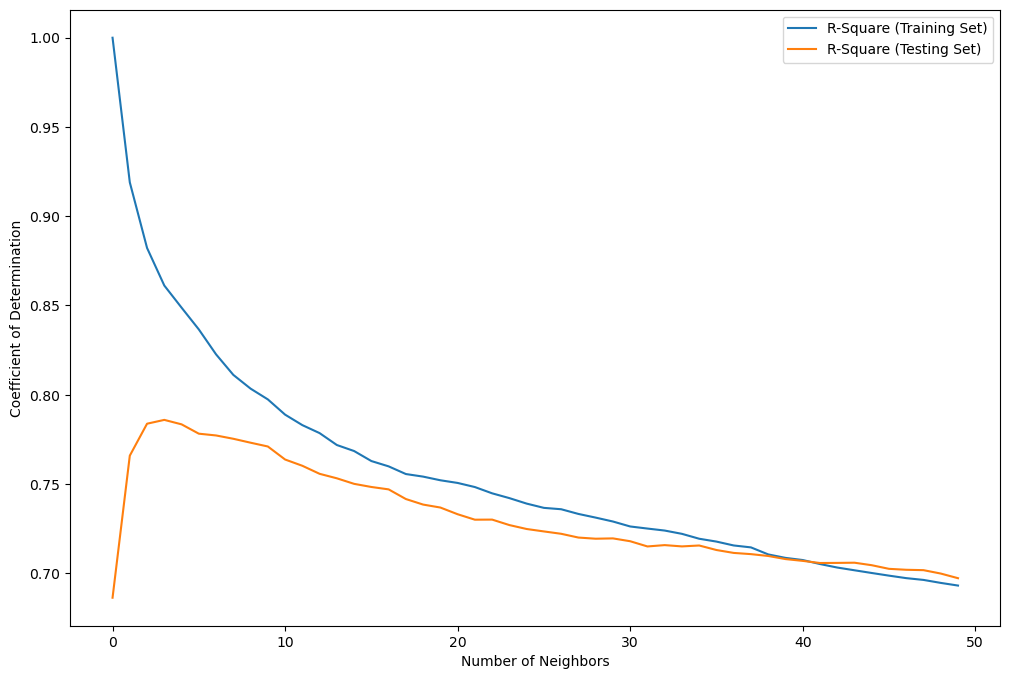

The optimal number of neighbors is 41


In [42]:
# visualizing KNN results
opt_neighbors(x_log_train   = x_log_train,
                  y_log_train   = y_log_train,
                  x_log_test    = x_log_test,
                  y_log_test    = y_log_test,
                  max_neighbors = 50)

This graph illustrates the performance of the k-Nearest Neighbors (kNN) model in predicting housing prices, with a focus on how the number of neighbors influences the model's accuracy, measured by the Coefficient of Determination (R²). The blue line represents the R² for the training set, which sharply declines as the number of neighbors increases, indicating that the model fits the training data less effectively with more neighbors. The orange line represents the testing set shows an initial improvement in performance as neighbors increase, stabilizes, and then gradually decreases, suggesting the model generalizes better up to a point before overfitting. The optimal number of neighbors, where the testing set performance peaks, is 48. This suggests that beyond this point, the model's ability to predict accurately diminishes.

In [43]:
# Model with the optimal number of neighbors
knn_opt = KNeighborsRegressor(algorithm   = 'auto',
                              n_neighbors = 48)



# Fit the model based on the training data
knn_opt_fit = knn_opt.fit(x_log_train, y_log_train)



# Predict on new data
knn_opt_pred = knn_opt_fit.predict(x_log_test)


# Score the results
knn_opt_score_train = round(knn_opt.score(x_log_train, y_log_train), ndigits = 4)
knn_opt_score_test  = round(knn_opt.score(x_log_test, y_log_test), ndigits = 4)
knn_opt_test_gap    = round(abs(knn_opt_score_train - knn_opt_score_test), ndigits = 4)


# Check results
print(f"""
K-Nearest Neighbors
-------------------
Training Score: {knn_opt_score_train}
Testing Score : {knn_opt_score_test}
Train-Test Gap: {knn_opt_test_gap}
""")


K-Nearest Neighbors
-------------------
Training Score: 0.6249
Testing Score : 0.6278
Train-Test Gap: 0.0029



## Kaggle Submission

In [44]:
# INSTANTIATING and FITTING model objects for non log data
model      = sklearn.linear_model.LinearRegression().fit(x_data, y_data)
sqrt_model = sklearn.linear_model.LinearRegression().fit(x_data, sqrt_y_data)

# checking R-Squared values
print(f'Original Units: {round(model.score(x_data, y_data), ndigits = 4)}')
print(f'Square Rooted Units: {round(sqrt_model.score(x_data, sqrt_y_data), ndigits = 4)}')
print(f'Linear Log Model: {round(linear_model.score(x_log_data, y_log_data), ndigits = 4)}')
print(f'Ridge Log Model: {round(Ridge_model.score(x_log_data, y_log_data), ndigits = 4)}')
print(f'Lasso Log Model: {round(lasso_model.score(x_log_data, y_log_data), ndigits = 4)}')
print(f'SGD Log Model: {round(SGD_model.score(x_log_data, y_log_data), ndigits = 4)}')
print(f'KNN Log Model: {round(knn_opt.score(x_log_data, y_log_data), ndigits = 4)}')

Original Units: 0.9029
Square Rooted Units: 0.9237
Linear Log Model: 0.9243
Ridge Log Model: 0.922
Lasso Log Model: 0.9223
SGD Log Model: 0.7475
KNN Log Model: 0.6257


In [45]:
# setting x_test
x_k_test  = kaggle_data[x_features]
x_k_log_test = kaggle_data[x_log_features]

# making predictions for each model
model_pred = model.predict(x_k_test)
sqrt_model_pred = sqrt_model.predict(x_k_test)
linear_log_model = linear_model.predict(x_k_log_test)
ridge_log_model = Ridge_model.predict(x_k_log_test)
lasso_log_model = lasso_model.predict(x_k_log_test)
SDG_log_model = SGD_model.predict(x_k_log_test)
knn_log_model = knn_opt.predict(x_k_log_test)

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>
Below we are inversing the logarithmic and square rooted predictions using their mathematical counterparts. Afterwards, all sets of predictions are in the same units as the original sale price values, and Kaggle is able to evaluate them properly.

In [46]:
## Inverse Transformations ##
inv_predictions = pd.DataFrame({"Model_pred": model_pred,
                                "Sqrt_model_pred": sqrt_model_pred ** 2,
                                "Linear_model_pred": np.expm1(linear_log_model),
                                "Ridge_model_pred": np.expm1(ridge_log_model),
                                "Lasso_model_pred": np.expm1(lasso_log_model),
                                "SGD_model_pred": np.expm1(SDG_log_model),
                                "Knn_opt_pred": np.expm1(knn_log_model)})


# checking results
inv_predictions.head(n = 5)

,Model_pred,Sqrt_model_pred,Linear_model_pred,Ridge_model_pred,Lasso_model_pred,SGD_model_pred,Knn_opt_pred
0,135110.897544,134240.358621,118342.493981,117060.263816,118724.055068,112621.644999,150579.238656
1,172293.723295,169432.269924,165651.118715,164362.095704,165080.451950,202155.123474,148790.377366
2,180741.103938,177840.991652,183821.601182,184191.442196,184435.460931,169978.864023,208395.430851
3,190604.271884,193918.664710,193272.948235,194305.591831,194474.073301,180209.901442,217018.375461
4,214333.278210,206055.611296,205856.352516,206436.749724,205039.795468,160121.936015,166458.740584


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Preparing Submission File for Kaggle</h2><br>
From here, we can simply create a DataFrame with the original Ids and the predicted values from whichever model we choose. As an example, the code below prepares a Kaggle submission for the inversed logarithmic predictions.

In [47]:
# saving predictions with their respective Ids from the test set
predictions = pd.DataFrame(data = { 'Id'        : housing_test['Id'],
                                    'SalePrice' : inv_predictions['Lasso_model_pred']} )

# checking the results
predictions.head(n = 5)

,Id,SalePrice
0,1461,118724.055068
1,1462,165080.451950
2,1463,184435.460931
3,1464,194474.073301
4,1465,205039.795468


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>
Finally, we save the DataFrame as a .csv file and we're ready to submit. This file will be available in Output > /kaggle/working > submission.csv.

In [48]:
# sending predictions to .csv file
predictions.to_csv(path_or_buf = 'submission.csv',
                   index = False)

## Conclusion
On one hand, the linear model gave the best R-squared value but the gap between testing and training scores was one of the highest. On the other hand, the Lasso model gave the second best r-squared value but with a much lower gap. This is why the score was better for the Lasso than for the Linear. This shows that the r-square value on its own is not enough to fully showcase the predictive accuracy of a model. It is very important to consider the RMSE as well to actually know the accuracy of the predictions and the actual data